In [40]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.switch_backend('Qt5Agg')
import matplotlib.colors
from sklearn.preprocessing import MinMaxScaler,OneHotEncoder
from sklearn.datasets import make_moons
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import imageio
import itertools
from sklearn.metrics import accuracy_score,mean_squared_error
import matplotlib.animation as animation
import seaborn as sns
import sys
from IPython.display import HTML


In [4]:
class FFSN_MultiClass:
  
  def __init__(self,n_inputs,n_outputs,hidden_sizes=[3]):
    self.nx=n_inputs
    self.ny=n_outputs
    self.nh=len(hidden_sizes)
    self.sizes=[self.nx]+hidden_sizes+[self.ny]
    self.W={}
    self.B={}
    
    for i in range(self.nh+1):
      self.W[i+1]=np.random.randn(self.sizes[i],self.sizes[i+1])
      self.B[i+1]=np.zeros((1,self.sizes[i+1]))
   
  def sigmoid(self,x):
    return 1.0/(1.0+np.exp(-x))
  
  def softmax(self,x):
    exps=np.exp(x)
    return exps/np.sum(exps)
  
  
  def forward_pass(self,x):
    self.A={}
    self.H={}
    self.H[0]=x.reshape(1,-1)
    for i in range(self.nh):
      self.A[i+1]=np.matmul(self.H[i],self.W[i+1])+self.B[i+1]
      self.H[i+1]=self.sigmoid(self.A[i+1])
    self.A[self.nh+1]=np.matmul(self.H[self.nh],self.W[self.nh+1])+self.B[self.nh+1]
    self.H[self.nh+1]=self.softmax(self.A[self.nh+1])
    return self.H[self.nh+1]
  
  def predict(self,X):
    Y_pred=[]
    for x in X:
      y_pred=self.forward_pass(x)
      Y_pred.append(y_pred)
    return np.array(Y_pred).squeeze()
  
  def predict_H(self,X,layer,neuron):
    assert layer<len(self.sizes) ,"Layer cant be greater than maximum layers"
    assert neuron<self.sizes[layer] ,"Exceeds the total neuron in layer{}".format(layer)

    Y_pred=[]
    for x in X:
      y_pred=self.forward_pass(x)
      Y_pred.append([item[neuron] for item in self.H[layer]])
    return np.array(Y_pred)
  
  def grad_sigmoid(self,x):
    return x*(1-x)
  
  def cross_entropy(self,label,pred):
    y1=np.multiply(pred,label)
    y1=y1[y1!=0]
    y1=-np.log(y1)
    y1=np.mean(y1)
    return y1
    
    
  def grad(self,x,y):
    self.forward_pass(x)
    self.dW={}
    self.dB={}
    self.dH={}
    self.dA={}
    L=self.nh+1
    self.dA[L]=(self.H[L]-y)
    for k in range(L,0,-1):
      self.dW[k]=np.matmul(self.H[k-1].T,self.dA[k])
      self.dB[k]=self.dA[k]
      self.dH[k-1]=np.matmul(self.dA[k],self.W[k].T)
      self.dA[k-1]=np.multiply(self.dH[k-1],self.grad_sigmoid(self.H[k-1]))
 
  def fit(self,X,Y,epochs=100,initialize=True,learning_rate=1,display_loss=False,display_weights=False):
    if display_loss:
      loss={}
      
    if display_weights:
      self.weights=[]
      
    if initialize:
      for i in range(self.nh+1):
        self.W[i+1]=np.random.randn(self.sizes[i],self.sizes[i+1])
        self.B[i+1]=np.zeros((1,self.sizes[i+1]))
        
    for epoch in tqdm_notebook(range(epochs),total=epochs,unit="epochs"):
      dW={}
      dB={}
      for i in range(self.nh+1):
        dW[i+1]=np.zeros((self.sizes[i],self.sizes[i+1]))
        dB[i+1]=np.zeros((1,self.sizes[i+1]))
      for x,y in zip(X,Y):
        self.grad(x,y)
        for i in range(self.nh+1):
          dW[i+1]+=self.dW[i+1]
          dB[i+1]+=self.dB[i+1]
    
      m=X.shape[1]
      for i in range(self.nh+1):
        self.W[i+1] -=learning_rate * (dW[i+1]/m)
        self.B[i+1] -=learning_rate * (dB[i+1]/m)
        
      if display_loss:
        Y_pred=self.predict(X)
        loss[epoch]=self.cross_entropy(Y,Y_pred)
      
      if display_weights:
        weights=[]
        max_neuron_layr=max(self.sizes)
        for i in range(self.nh+1):
          if max_neuron_layr==len(self.W[i+1][0]):
            weights.append(list(itertools.chain(*self.W[i+1].tolist())))
            
          else:
            for j in self.W[i+1].tolist():
              j.append(0.0)
              weights.append(j)
              
          
        self.weights.append(list(itertools.chain(*weights)))
        
      
    if display_loss:
      plt.plot(loss.values())
      plt.xlabel("Epochs")
      plt.ylabel("CE")
      plt.show()
    

In [5]:
my_cmap=matplotlib.colors.LinearSegmentedColormap.from_list('',['red',"green"])

((1000L, 2L), (1000L,))


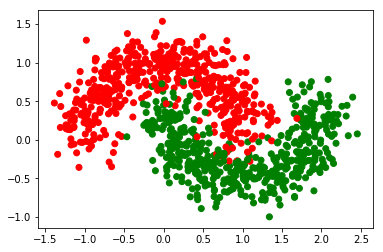

In [6]:
data,labels=make_moons(n_samples=1000,noise=0.2,random_state=0)
print(data.shape,labels.shape)
plt.scatter(data[:,0],data[:,1],c=labels,cmap=my_cmap)
plt.show()

In [7]:
X_train,X_val,Y_train,Y_val=train_test_split(data,labels,stratify=labels,random_state=0)
print(X_train.shape,X_val.shape)
print(Y_train.shape,Y_val.shape)

((750L, 2L), (250L, 2L))
((750L,), (250L,))


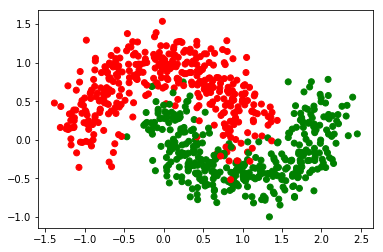

In [8]:
plt.scatter(X_train[:,0],X_train[:,1],c=Y_train,cmap=my_cmap)

In [9]:
ohc=OneHotEncoder()
y_OH_train=ohc.fit_transform(np.expand_dims(Y_train,1)).toarray()
y_OH_val=ohc.fit_transform(np.expand_dims(Y_val,1)).toarray()
print(y_OH_train.shape,y_OH_val.shape)

((750L, 2L), (250L, 2L))


HBox(children=(IntProgress(value=0, max=2000), HTML(value=u'')))

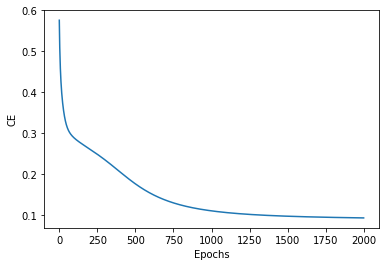

Training Accuracy 0.964 and validation accuracy is 0.968


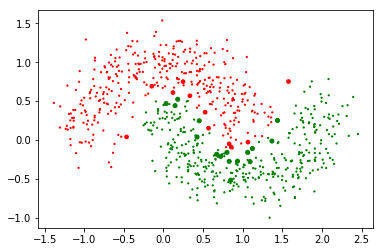

In [10]:
ffsn_multi=FFSN_MultiClass(2,2,[15,15])
#ffsn_multi.fit(X_train,y_OH_train,epochs=1000,learning_rate=0.0015,initialize=True,display_loss=True)
ffsn_multi.fit(X_train,y_OH_train,epochs=2000,learning_rate=0.0011,initialize=True,display_loss=True,display_weights=True)
Y_pred_train=ffsn_multi.predict(X_train)
Y_pred_train=np.argmax(Y_pred_train,1)
Y_pred_val=ffsn_multi.predict(X_val)
Y_pred_val=np.argmax(Y_pred_val,1)

accuracy_train=accuracy_score(Y_pred_train,Y_train)
accuracy_test=accuracy_score(Y_pred_val,Y_val)
print("Training Accuracy {} and validation accuracy is {}".format(accuracy_train,accuracy_test))

plt.scatter(X_train[:,0],X_train[:,1],c=Y_pred_train,cmap=my_cmap,s=np.abs(np.sign(Y_pred_train-Y_train)+0.1)*15)

# # Code to recursively store the animation in local drive. However please note that animation.writer (ffmpeg) need to be available in order to create a video
print(matplotlib.animation.writers.list())

In [ ]:
sizes=ffsn_multi.sizes
def save_animation(l,n):
    frames=20
    fig,ax=plt.subplots(figsize=(10,5))
    def make_meshgrid(x,y,h=0.2):
        x_min,x_max=x.min()-0.5,x.max()+0.5
        y_min,y_max=y.min()-0.5,y.max()+0.5
        xx,yy=np.meshgrid(np.arange(x_min,x_max,h),np.arange(y_min,y_max,h))
        return xx,yy
    xx,yy=make_meshgrid(X_train[:,0],X_train[:,1])
    z=ffsn_multi.predict_H(np.c_[xx.ravel(),yy.ravel()],l,n).reshape(xx.shape)

    def plot_contour(i):
        out=ax.contourf(xx,yy,z,alpha=0.2,cmap=my_cmap)
        ax.scatter(X_train[:,0],X_train[:,1],c=Y_train,cmap=my_cmap)
        ax.set_xlim(xx.min(),xx.max())
        ax.set_ylim(yy.min(),yy.max())
        ax.set_xlabel("X1")
        ax.set_ylabel("X2")
        ax.set_title("Layer {} and neuron {}".format(l,n))
        return out
    
    anim=animation.FuncAnimation(fig, plot_contour, frames=frames, repeat=True)
    #anim.
    HTML(anim.to_jshtml())
    #anim.save("F:\\images\\{}_{}.mp4".format(l,n),writer=writer)
    #HTML(anim.to_html5_video())
save_animation(1,2)
#writer = animation.FFMpegWriter(fps=30)
#writer = Writer(fps=15, metadata=dict(artist='Akshay Jain'), bitrate=1800)
#for i in range(len(sizes)):
#    for j in range(sizes[i]):
#        save_animation(i,j)
#        print("Animation Saved for layer {} and neuron {}".format(i,j))
#print(sizes)

#Generating animation for weights inside a DNN to check what is happening inside a DNN

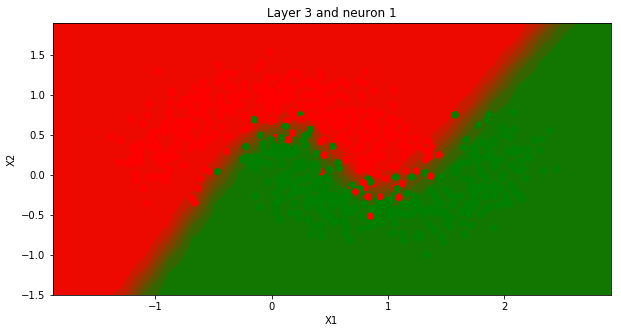

In [70]:
frames=20
l=3
n=1



fig,ax=plt.subplots(figsize=(10,5))
def make_meshgrid(x,y,h=0.2):
    x_min,x_max=x.min()-0.5,x.max()+0.5
    y_min,y_max=y.min()-0.5,y.max()+0.5
    xx,yy=np.meshgrid(np.arange(x_min,x_max,h),np.arange(y_min,y_max,h))
    return xx,yy
xx,yy=make_meshgrid(X_train[:,0],X_train[:,1])
z=ffsn_multi.predict_H(np.c_[xx.ravel(),yy.ravel()],l,n).reshape(xx.shape)

def plot_contour(i):
    out=ax.contourf(xx,yy,z,alpha=0.2,cmap=my_cmap)
    ax.scatter(X_train[:,0],X_train[:,1],c=Y_train,cmap=my_cmap)
    ax.set_xlim(xx.min(),xx.max())
    ax.set_ylim(yy.min(),yy.max())
    ax.set_xlabel("X1")
    ax.set_ylabel("X2")
    ax.set_title("Layer {} and neuron {}".format(l,n))
    return out


anim=animation.FuncAnimation(fig, plot_contour, frames=frames, repeat=True)
HTML(anim.to_jshtml())
#anim.save("{}_{}.mp4")
#print(matplotlib.animation.writers.list())

In [ ]:
from moviepy.editor import VideoFileClip, concatenate_videoclips

clips=[]
for i in range(len(sizes)):
    for j in range(sizes[i]):
        #print(i,j)
        clips.append(VideoFileClip("{}_{}.mp4".format(i,j)))
        
final_clip = concatenate_videoclips(clips)
final_clip.write_videofile("my_concatenation.mp4")
#print(clip[0])




